<p style="color: #000000; font-size: 32px; font-weight: bold; text-align: center; margin-top: 20px;"> 
Customer Churn Prediction for Beta Bank 
</p>
<p style="color: #000000; font-size: 24px; text-align: center; margin-bottom: 20px;">
F1 Optimization and AUC-ROC Evaluation
</p>

<hr style="border: .4px solid #000000; width: 55%; margin: 10px auto;">


<p style="color: #000000; font-size: 18px;">
Beta Bank's customers are gradually leaving the bank every month. Bankers have identified that retaining current customers is more cost-effective than acquiring new ones.
</p>
<p style="color: #000000; font-size: 20px; font-weight: bold;">Project Objective:</p>
<p style="color: #000000; font-size: 18px;">
The objective of this project is to predict whether a Beta Bank customer will leave the bank in the near future, using historical data on customer behavior and contract terminations.
</p>

<p style="color: #000000; font-size: 20px; font-weight: bold;">Project Goals:</p>
<ul style="color: #000000; font-size: 18px;">
<li><strong>Predict customer churn:</strong> Develop a model to predict if a customer will leave the bank soon.</li>
<li><strong>Optimize the F1 score:</strong> The model must achieve an F1 score of at least 0.59 to be approved.</li>
<li><strong>Measure the AUC-ROC metric:</strong> Evaluate the model's quality using the AUC-ROC metric and compare it with the F1 score.</li>
</ul>

# 1. Data Description

### `Churn` dataframe: 

**`RowNumber`**: Index of the data row  
**`CustomerId`**: Unique customer identifier  
**`Surname`**: Last name  
**`CreditScore`**: Credit score  
**`Geography`**: Country of residence  
**`Gender`**: Gender  
**`Age`**: Age  
**`Tenure`**: Duration of the customer's fixed-term deposit maturity (in years)  
**`Balance`**: Account balance  
**`NumOfProducts`**: Number of bank products used by the customer  
**`HasCrCard`**: Whether the customer has a credit card (1 - yes; 0 - no)  
**`IsActiveMember`**: Customer activity status (1 - yes; 0 - no)  
**`EstimatedSalary`**: Estimated salary  

**Target column**    
**`Exited`**: Whether the customer has left (1 - yes; 0 - no)  

# 2. Libraries and Data Loading  

In [51]:
# Load libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

In [9]:
# Load the data
df = pd.read_csv('Churn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [10]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


**Initial DataFrame Review**:

- The DataFrame contains **10,000 rows** and **14 columns**.

- The `dtypes` match the column names and descriptions, except for the `tenure` column, which will be converted to `int64`. Additionally, categorical columns will be converted to numerical values using pandas' **`get_dummies`** function.

- The only column with null values is **`Tenure`**, with a total of **909 missing values**.

- According to Python's best coding practices, variable and function names should follow the **snake_case** format, and adjustments will be made accordingly.

- Unnecessary columns such as `RowNumber`, `CustomerId`, and `Surname` will be **removed**.

Furthermore, the data will be analyzed to check for duplicates, and a thorough review will be conducted to ensure column values are consistent, logically valid, and free of errors. This includes examining for outliers, typos, and duplicate columns.

# 3. Data Preprocessing

In [11]:
# Delete columns 'RowNumber','CustomerId','Surname'
df = df.drop(['RowNumber','CustomerId','Surname'],axis=1)

In [12]:
# Change column names to snake_case
df.columns = [re.sub(r'([a-z0-9])([A-Z])', r'\1_\2', col).lower() for col in df.columns]
print('Column names in snake_case:\n', df.columns.tolist())

Column names in snake_case:
 ['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary', 'exited']


In [13]:
# Count the number of duplicate rows in the DataFrame
print('Total duplicates in DataFrame:', df.duplicated().sum())

Total duplicates in DataFrame: 0


In the **`tenure`** column, 9.09% of the values are missing, which is a significant percentage to simply discard. Tenure represents the period during which a customer's fixed-term deposit has matured (in years), so the missing values might indicate that the customer does not have one. This leads to filling the missing values with 0.

In [14]:
# Fill out NAs with 0
df['tenure'] = df['tenure'].fillna(0)  
# Count missing values in the 'tenure' column
missing_values = df['tenure'].isnull().sum()
# Result
print(f"Missing values in 'tenure': {missing_values}")

Missing values in 'tenure': 0


In [15]:
# Convert dtype
df['tenure'] = df['tenure'].astype(int)
print("'tenure' dtype:", df['tenure'].dtype)


'tenure' dtype: int64


The **`geography`** and **`gender`** columns will be examined for outliers.

In [16]:
print("Unique entries in 'geography' column:", df['geography'].unique())

Unique entries in 'geography' column: ['France' 'Spain' 'Germany']


In [17]:
print("Unique entries in 'gender' column:", df['gender'].unique())

Unique entries in 'gender' column: ['Female' 'Male']


The pandas **`get_dummies`** function is used to convert categorical variables into numerical variables.  
This process is known as **one-hot encoding**. It will be applied to the **`geography`** and **`gender`** columns.  
To avoid the **dummy trap**, `drop_first=True` will be used when creating the dummy variables, removing one category and preventing multicollinearity.

In [18]:
df = pd.get_dummies(df, columns=['geography', 'gender'], drop_first=True)
df = df.astype(int) # convert dummy columns to integer type (1 and 0)

In [19]:
df.columns = df.columns.str.lower() # convert to lowercase
df.columns = df.columns.str.replace('geography_', 'geo_').str.replace('gender_', 'gen_') # shorter names
df.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geo_germany,geo_spain,gen_male
0,619,42,2,0,1,1,1,101348,1,0,0,0
1,608,41,1,83807,1,0,1,112542,0,0,1,0
2,502,42,8,159660,3,1,0,113931,1,0,0,0
3,699,39,1,0,2,0,0,93826,0,0,0,0
4,850,43,2,125510,1,1,1,79084,0,0,1,0


For better clarity, in the **`geography_germany`** column, **0** corresponds to `France`, and **1** to `Germany`. In the **`geography_spain`** column, **1** corresponds to `Spain`. In **`gender_male`**, **0** corresponds to `Male`, and **1** to `Female`.

Now, let's move on to the next phase of the project: **`Modeling`**. In this phase, we will prepare the training, validation, and test datasets.

# 4. Modeling  

The goal is to train the model, validate it, and then conduct final testing. To achieve this, we need three separate datasets. Since Beta Bank has only provided one dataset, it will be split into three parts: a training set, a validation set, and a test set. A common ratio for splitting the data is 3:1:1, where the training set contains 60% of the data, and both the validation and test sets contain 20% of the data each.  
To perform this split, we will use the **`train_test_split`** function from the **`sklearn.model_selection`** library.  
The following code block will split the original dataset into these three sets.  

In [20]:
# Create the target dataset by selecting the 'Exited' column
target = df['exited']  # Target variable we want to predict

# Create the features dataset by dropping the 'Exited' column
features = df.drop('exited', axis=1)  # Ensures the features dataset contains only predictor variables

In [21]:
# Split the features and target into training sets (60%) and the remaining sets (40%)

# 'features_train' and 'target_train' contain 60% of the data for training
features_train, features_other, target_train, target_other = train_test_split(
    features, target, test_size=0.4, random_state=12345
)  
# 'features_other' and 'target_other' contain 40%, which will be split into validation and test sets
features_valid, features_test, target_valid, target_test = train_test_split(
    features_other, target_other, test_size=0.5, random_state=12345
)

**`test_size=0.4`** assigns 40% (4,000 rows) to validation/testing and leaves 60% (6,000 rows) for training.  
**`test_size=0.5`** splits the remaining 40% (4,000 rows) into two equal parts: 20% (2,000 rows) for validation and 20% (2,000 rows) for testing.  
**`random_state=12345`** ensures that the splits are consistent every time the code is executed.  

In [24]:
# Verify that the splits have been created correctly

# View the shape of the training set (60%)
print('Training set dimensions (features_train):', features_train.shape)
print('Training set dimensions (target_train):', target_train.shape)

# View the shape of the validation set (20%)
print('\nValidation set dimensions (features_valid):', features_valid.shape)
print('Validation set dimensions (target_valid):', target_valid.shape)

# View the shape of the test set (20%)
print('\nTest set dimensions (features_test):', features_test.shape)
print('Test set dimensions (target_test):', target_test.shape)

Training set dimensions (features_train): (6000, 11)
Training set dimensions (target_train): (6000,)

Validation set dimensions (features_valid): (2000, 11)
Validation set dimensions (target_valid): (2000,)

Test set dimensions (features_test): (2000, 11)
Test set dimensions (target_test): (2000,)


After the data split, it is important to check whether the class distribution is balanced or not across the three datasets.

### Class Distribution  

In [25]:
# Class balance for the training dataset
print('TRAINING')
print(f'Negative class balance: {round(target_train[target_train == 0].count() * 100 / len(target_train), 3)}%') 
print(f'Positive class balance: {round(target_train[target_train == 1].count() * 100 / len(target_train), 3)}%\n') 

# Class balance for the validation dataset
print('VALIDATION')
print(f'Negative class balance: {round(target_valid[target_valid == 0].count() * 100 / len(target_valid), 3)}%') 
print(f'Positive class balance: {round(target_valid[target_valid == 1].count() * 100 / len(target_valid), 3)}%\n') 

# Class balance for the test dataset
print('TEST')
print(f'Negative class balance: {round(target_test[target_test == 0].count() * 100 / len(target_test), 3)}%') 
print(f'Positive class balance: {round(target_test[target_test == 1].count() * 100 / len(target_test), 3)}%')

TRAINING
Negative class balance: 80.067%
Positive class balance: 19.933%

VALIDATION
Negative class balance: 79.1%
Positive class balance: 20.9%

TEST
Negative class balance: 78.85%
Positive class balance: 21.15%


The dataset exhibits a class imbalance, where the **negative class represents approximately 80%**, and the **positive class accounts for 20%** across the training, validation, and test sets.  
These figures reflect the imbalance between classes in the datasets:  
- **Negative class**: Percentage of instances labeled as the negative class (e.g., 0 or "no").  
- **Positive class**: Percentage of instances labeled as the positive class (e.g., 1 or "yes").  

This indicates a **class imbalance**, where the negative class is significantly more frequent. This imbalance may cause the model to favor predicting the negative class. To address this, techniques such as oversampling the positive class or using algorithms that adjust class weights should be applied.

Before training, we need to standardize the data to treat all features equally by using the **`StandardScaler`** class from the **`sklearn.preprocessing`** module, as shown in the next step.

In [27]:
# Select the numerical columns from the DataFrame
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler only on the training set
scaler.fit(features_train[numeric])

# Transform the training data using the fitted scaler
features_train.loc[:, numeric] = scaler.transform(features_train.loc[:, numeric])

# Transform the validation and test data using the parameters from the training set
features_valid.loc[:, numeric] = scaler.transform(features_valid.loc[:, numeric])
features_test.loc[:, numeric] = scaler.transform(features_test.loc[:, numeric])

In [28]:
# Verify statistics after standardization for training, validation, and test sets
print("Training set statistics (features_train):")
display(features_train[numeric].describe())

print("\nValidation set statistics (features_valid):")
display(features_valid[numeric].describe())

print("\nTest set statistics (features_test):")
display(features_test[numeric].describe())

Training set statistics (features_train):


,credit_score,age,tenure,balance,num_of_products,estimated_salary
count,6.000000e+03,6.000000e+03,6.000000e+03,6.000000e+03,6.000000e+03,6.000000e+03
mean,-4.553395e-16,9.710751e-17,1.397401e-16,3.789561e-17,-5.329071e-17,8.052818e-17
std,1.000083e+00,1.000083e+00,1.000083e+00,1.000083e+00,1.000083e+00,1.000083e+00
min,-3.140255e+00,-1.986549e+00,-1.468729e+00,-1.233162e+00,-8.915599e-01,-1.723000e+00
25%,-6.894392e-01,-6.579018e-01,-8.253725e-01,-1.233162e+00,-8.915599e-01,-8.642681e-01
50%,2.192061e-02,-1.833849e-01,1.396619e-01,3.262444e-01,-8.915599e-01,1.114228e-02
75%,6.709715e-01,4.809386e-01,7.830182e-01,8.219482e-01,8.301522e-01,8.485936e-01
max,2.052152e+00,5.036300e+00,1.748053e+00,2.806172e+00,4.273576e+00,1.739050e+00



Validation set statistics (features_valid):


,credit_score,age,tenure,balance,num_of_products,estimated_salary
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,-0.054911,-0.001076,-0.052702,0.012940,0.051938,0.028253
std,1.002073,1.016118,0.996434,1.009242,1.008146,1.003187
min,-2.984483,-1.986549,-1.468729,-1.233162,-0.891560,-1.721632
25%,-0.762133,-0.657902,-0.825373,-1.233162,-0.891560,-0.838978
50%,-0.035196,-0.183385,-0.182016,0.358290,0.830152,0.007237
75%,0.660587,0.480939,0.783018,0.829414,0.830152,0.916203
max,2.052152,5.036300,1.748053,2.604751,4.273576,1.740106



Test set statistics (features_test):


,credit_score,age,tenure,balance,num_of_products,estimated_salary
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,-0.041686,-0.003923,0.016620,-0.021850,0.054521,0.023106
std,1.015290,0.959877,1.007017,1.013441,0.997580,0.976558
min,-3.140255,-1.986549,-1.468729,-1.233162,-0.891560,-1.720731
25%,-0.762133,-0.657902,-0.825373,-1.233162,-0.891560,-0.769394
50%,-0.045581,-0.183385,0.139662,0.318299,0.830152,0.018806
75%,0.691741,0.480939,0.783018,0.814800,0.830152,0.855660
max,2.052152,3.992363,1.748053,2.333394,4.273576,1.740487


The data has been standardized correctly, as all the statistics align with the expected results after applying **`StandardScaler`**. The means are close to 0, the standard deviations are approximately 1, and the numerical column values across the three datasets follow the expected standardized distribution.

## 4.1 Logistic Regression

### 4.1.1 Without Class Imbalance Adjustment

We will now train a model without adjusting for class imbalance. Later, we will compare the results with a model trained after addressing the imbalance.

In [29]:
# Create an instance of the LogisticRegression model
model = LogisticRegression(solver='liblinear', random_state=12345)

# Fit the model using the training data
model.fit(features_train, target_train)

# Predict target values for the validation features
predicted_val = model.predict(features_valid)

# Calculate and print the F1 score
print('F1 Score - Logistic Regression:', round(f1_score(target_valid, predicted_val), 5))

# Obtain the prediction probabilities
probabilities_val = model.predict_proba(features_valid)

# Extract the probabilities for the positive class (1)
probabilities_one_val = probabilities_val[:, 1]

# Calculate and display the AUC-ROC score
auc_roc = roc_auc_score(target_valid, probabilities_one_val)
print(f'AUC-ROC Score: {round(auc_roc, 5)}')

F1 Score - Logistic Regression: 0.3339
AUC-ROC Score: 0.75863


**Logistic Regression Model Evaluation:**  

- **F1 Score**: 0.33 (without class imbalance adjustment). This value is acceptable but not satisfactory for Beta Bank's needs.  
- **AUC-ROC**: 0.76, which is better than a random model but still not ideal.  

We will reassess the model's performance after addressing the class imbalance, as it does not meet the expectations set by Beta Bank.  

### 4.1.2 Class Imbalance Adjustment  

To improve the F1 score of the logistic regression model, we will address the class imbalance in the training dataset.  
By modifying the class weights, the model becomes more sensitive to the less frequent classes. This is achieved by setting the `class_weight` parameter to `balanced` when initializing the model. The model will then be trained with this adjustment to enhance the F1 score.  
This adjustment helps prevent the model from being biased toward the more common classes and improves its performance on underrepresented classes.

In [30]:
# Create an instance of the LogisticRegression model
# The parameter class_weight='balanced' adjusts the class weights based on their frequencies
model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=12345)

# Fit the model using the training data
model.fit(features_train, target_train)

# Predict target values using the validation features
predicted_valid = model.predict(features_valid)

# Calculate and display the F1 score
print('F1 Score - Logistic Regression (after balancing):', round(f1_score(target_valid, predicted_valid), 5))

# Obtain the predicted probabilities for the positive class
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

# Calculate and display the AUC-ROC score
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'AUC-ROC Score: {round(auc_roc, 5)}')

F1 Score - Logistic Regression (after balancing): 0.48889
AUC-ROC Score: 0.76358


**Result After Balancing Class Imbalance:**  

- **F1 Score:** Improved to **0.49** from **0.33**, but it is still below the minimum threshold of **0.59** required by Beta Bank.  
- **AUC-ROC:** Slight improvement observed.  

Next, we will explore alternative methods to handle class imbalance and train different models to identify the optimal solution.

### 4.1.3 Upsampling and Downsampling Techniques  

First, we will apply **upsampling**, and then we will create a function for this purpose.

- **Upsampling**: Increases the number of positive instances in the dataset.

In [31]:
# Adjust class imbalance with oversampling

# Create a function to perform oversampling on the training data
def upsample(features, target, repeat):
    # Create subsets of data based on the classes
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    # Perform oversampling by replicating the minority class
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # Shuffle the observations to avoid patterns
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    # Return the balanced data
    return features_upsampled, target_upsampled

In [32]:
# Call the oversampling function to balance the classes
# Use a repetition factor of 10 for the minority class
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

In [33]:
# Create a logistic regression model instance
# The parameter class_weight='balanced' is used to address class imbalance
model = LogisticRegression(solver='liblinear', random_state=12345)

# Train the model with the oversampled training data
model.fit(features_upsampled, target_upsampled)

# Predict target values for the validation set
predicted_valid = model.predict(features_valid)

# Calculate and display the F1 score
print('F1 Score - Logistic Regression (after upsampling):', round(f1_score(target_valid, predicted_valid), 5))

# Calculate probabilities for the positive class
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

# Calculate and display the AUC-ROC score
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'AUC-ROC Score: {round(auc_roc, 5)}')

F1 Score - Logistic Regression (after upsampling): 0.41989
AUC-ROC Score: 0.765


**Result after Upsampling:**

The model's **F1 score** after performing **upsampling** on the data is **0.42**, which is lower than the **0.49** previously achieved using the **`class_weight`** parameter. However, it is better than not addressing the class imbalance at all.

The **AUC-ROC** remains similar to the result obtained with the model that used the **`class_weight='balanced'`** parameter.

Next, we will test **downsampling** to evaluate its impact on the model.

- **Downsampling**: Reduces the number of negative instances in the dataset.

In [35]:
# Create a function to downsample the training data
def downsample(features, target, fraction):
    # Split features and target into two groups based on the class (0 and 1)
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    # Randomly downsample class 0 and combine it with class 1
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    # Randomly shuffle the downsampled data
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

In [36]:
# Downsample the training data with a fraction of 0.1
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

In [38]:
# Create an instance of the Logistic Regression model
# Pass the parameter class_weight='balanced' to handle imbalanced classes
model = LogisticRegression(solver='liblinear', random_state=12345)

# Train the model using the downsampled training data
model.fit(features_downsampled, target_downsampled)

# Predict the target values for the validation dataset
predicted_valid = model.predict(features_valid)

# Calculate and print the F1 score
print('F1 Score - Logistic Regression (after downsampling):', f1_score(target_valid, predicted_valid))

# Calculate the probabilities for the positive class in the validation dataset
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

# Calculate and print the AUC-ROC score
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'AUC-ROC Score: {round(auc_roc, 5)}')

F1 Score - Logistic Regression (after downsampling): 0.4298642533936652
AUC-ROC Score: 0.75826


**Result after downsampling:**  
The new model has an F1 score of approximately **0.43**, which is an improvement over the model with upsampled data but does not surpass the model using the **`class_weight`** parameter.  

Regarding the **AUC-ROC** score, it remains nearly the same, with a slight decrease compared to the previous two models.  

Next, we will proceed with the **decision tree model** and conclude with the **random forest model**.

Now, we will evaluate the performance of the **`Decision Tree`** and **`Random Forest`** models by addressing the class imbalance using three methods: adjusting class weights with **`class_weight`**, increasing the minority class with **upsampling**, and reducing the majority class with **downsampling**. We will analyze how each technique impacts the performance of both models, comparing the results obtained with each method.

## 4.2 Decision Tree Model 

### 4.2.1 Adjusting Imbalanced Classes (class_weight='balanced') 


In [39]:
# Initialization
best_DT_model = None
best_DT_f1_score = 0
best_DT_depth = 0

# Create models with different depth values

# Loop to test different depth values (range from 1 to 41)
for depth in range(1, 42):
    
    # Create the model with the given depth and a fixed random_state
    DT_model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    
    # Train the model on the training dataset
    DT_model.fit(features_train, target_train)
    
    # Predict the target values for the validation set
    DT_valid_predictions = DT_model.predict(features_valid)  # get predictions from the model
    
    # Calculate the f1_score, if allowed
    try:
        f1 = f1_score(target_valid, DT_valid_predictions)
    except:
        break  # Exit the loop if there is an error
        
    # Determine the best model
    if f1 > best_DT_f1_score:
        best_DT_model = DT_model
        best_DT_depth = depth
        best_DT_f1_score = f1

# Get model probabilities for the validation set
valid_probabilities = best_DT_model.predict_proba(features_valid)
valid_probabilities_one = valid_probabilities[:, 1]

# Calculate AUC-ROC
auc_roc = roc_auc_score(target_valid, valid_probabilities_one)

# Results
print('Best Model:', best_DT_model)
print(f'Best F1 Score: {round(best_DT_f1_score, 4)}')
print(f'AUC-ROC Score: {round(auc_roc, 5)}')
print('Best Depth:', best_DT_depth)

Best Model: DecisionTreeClassifier(max_depth=9, random_state=12345)
Best F1 Score: 0.5787
AUC-ROC Score: 0.78997
Best Depth: 9


So far, the **highest F1 score** obtained is **0.58**, along with the **AUC-ROC** score of **0.79**.

### 4.2.2 Upsampling

In [40]:
# features_train, target_train -> original data

# Apply SMOTE to perform upsampling of the minority class
smote = SMOTE(random_state=12345)
features_upsampled, target_upsampled = smote.fit_resample(features_train, target_train)

# Initialize variables to find the best model
best_DT_model = None
best_DT_f1_score = 0
best_DT_depth = 0

# Create multiple models with different depth values
for depth in range(1, 41):
    
    # Create a decision tree model with the specified depth
    DT_model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    
    # Train the model with the balanced dataset
    DT_model.fit(features_upsampled, target_upsampled)
    
    # Predict target values for the validation features
    DT_predictions_valid = DT_model.predict(features_valid)
    
    # Calculate the F1 score
    try:
        f1 = f1_score(target_valid, DT_predictions_valid)
    except:
        break
    
    # Determine the best model
    if f1 > best_DT_f1_score:
        best_DT_model = DT_model
        best_DT_depth = depth
        best_DT_f1_score = f1

# Obtain prediction probabilities
probabilities_valid = best_DT_model.predict_proba(features_valid)

# Extract probabilities for the positive class (1)
probabilities_one_valid = probabilities_valid[:, 1]

# Calculate and display the AUC-ROC score
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

# Print the results
print('Best Model:', best_DT_model)
print(f'Best F1 Score: {round(best_DT_f1_score, 4)}')
print(f'AUC-ROC Score: {round(auc_roc, 5)}')
print('Best Depth:', best_DT_depth)

Best Model: DecisionTreeClassifier(max_depth=5, random_state=12345)
Best F1 Score: 0.5834
AUC-ROC Score: 0.82482
Best Depth: 5


This model achieved an **F1 score of 0.5834** and an **AUC-ROC of 0.82482**, demonstrating better performance in both metrics. Additionally, the best-performing model has an optimal depth of 5.

### 4.2.3 Downsampling

In [41]:
# Initialization of Variables
best_DT_model = None  # Best decision tree model
best_DT_f1_score = 0  # Best F1 score
best_DT_depth = 0  # Best depth

# Create models with different depth values

# For loop to iterate through depth values (range 1 to 40)
for depth in range(1, 41):
    
    # Create a model using the specified depth and the same random_state
    DT_model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    
    # Train the model using the training dataset
    DT_model.fit(features_downsampled, target_downsampled)
    
    # Predict target values for the validation dataset
    DT_predictions_valid = DT_model.predict(features_valid)  # Obtain model predictions on the validation set
    
    # Calculate the F1 score, if possible
    try:
        f1 = f1_score(target_valid, DT_predictions_valid)
    except:
        break  # Exit the loop if an error occurs
    
    # Determine the best model (based on the F1 score)
    if f1 > best_DT_f1_score:
        best_DT_model = DT_model  # Update the best model
        best_DT_depth = depth  # Update the best depth
        best_DT_f1_score = f1  # Update the best F1 score
        
# Calculate probabilities of the best prediction for the validation set
probabilities_valid = best_DT_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]  # Extract probabilities for the positive class (1)

# Calculate the AUC-ROC score
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

# Print the results
print('Best Model:', best_DT_model)
print(f'Best F1 Score: {round(best_DT_f1_score, 4)}')
print(f'AUC-ROC Score: {round(auc_roc, 5)}')
print('Best Depth:', best_DT_depth)

Best Model: DecisionTreeClassifier(max_depth=6, random_state=12345)
Best F1 Score: 0.4972
AUC-ROC Score: 0.80351
Best Depth: 6


The model with **max_depth=6** achieved an **F1 score of 0.4972** and an **AUC-ROC of 0.80351**, both of which are lower than the results obtained with the model having **max_depth=5** (F1 score of 0.5834 and AUC-ROC of 0.82482).

## 4.3 Random Forest Model

### 4.3.1 Balancing Classes with (class_weight='balanced') 

In [43]:
# Initialization of variables to store the best model and its parameters
best_RF_model = None
best_est = 0
best_RF_depth = 0
best_RF_f1_score = 0

# Loop to test different values of n_estimators (number of trees)
for est in range(1, 21):
    
    # Loop to test different values of max_depth (tree depth)
    for depth in range(1, 41):
        
        # Create the RandomForest model with the current parameters
        RF_model = RandomForestClassifier(max_depth=depth, random_state=12345, n_estimators=est)
        
        # Train the model with the training set
        RF_model.fit(features_train, target_train)

        # Predict the labels for the validation set
        RF_predictions_valid = RF_model.predict(features_valid)
       
        # Calculate the f1_score for the validation set
        f1 = f1_score(target_valid, RF_predictions_valid)

        # If the f1_score is better than the previous one, save the current model and its parameters
        if f1 > best_RF_f1_score:
            best_RF_model = RF_model
            best_RF_f1_score = f1
            best_RF_depth = depth
            best_est = est

# Obtain the probabilities of predictions for the validation set
probabilities_valid = best_RF_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

# Calculate the AUC-ROC for the obtained probabilities
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

# Display the results of the best model found
print('Best Model:', best_RF_model)
print(f'Best F1 Score: {round(best_RF_f1_score, 4)}')
print(f'AUC-ROC Score: {round(auc_roc, 5)}')
print('Best Depth (max_depth):', best_RF_depth)
print('Best n_estimators:', best_est)

Best Model: RandomForestClassifier(max_depth=19, n_estimators=11, random_state=12345)
Best F1 Score: 0.6099
AUC-ROC Score: 0.83079
Best Depth (max_depth): 19
Best n_estimators: 11


The **F1 score** achieved is **0.6099**, and the **AUC-ROC** is **0.83079**, both higher than those obtained with the decision tree model at **max_depth=5** (F1 score of **0.5834** and AUC-ROC of **0.82482**) and at **max_depth=6** (F1 score of **0.4972** and AUC-ROC of **0.80351**). These are the best results so far.

### 4.3.2 Upsampling

In [44]:
best_RF_model = None  # Best Random Forest model with Upsampling
best_est = 0  # Best number of estimators
best_RF_depth = 0  # Best depth
best_RF_f1_score = 0  # Best F1 score

# Create models with different depths and estimators

# Loop through the number of estimators
for est in range(1, 21):
    
    # Loop through the depth values
    for depth in range(1, 41):
        
        # Create the model with the specified depth and number of estimators
        RF_model = RandomForestClassifier(max_depth=depth, random_state=12345, n_estimators=est)
        
        # Train the model with the training dataset
        RF_model.fit(features_upsampled, target_upsampled)

        # Predict the target variable using the validation set
        RF_predictions_valid = RF_model.predict(features_valid)  # Predictions on the validation set
       
        # Calculate the F1 score
        try:
            f1 = f1_score(target_valid, RF_predictions_valid)
        except:
            break  # Exit the loop if an error occurs

        # Identify the best model with the highest F1 score
        if f1 > best_RF_f1_score:
            best_RF_model = RF_model
            best_RF_f1_score = f1
            best_RF_depth = depth
            best_est = est

# Calculate the probabilities for the validation set
probabilities_valid = best_RF_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]  # Probabilities of the positive class

# Calculate the AUC-ROC score
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

# Results
print('Best Model:', best_RF_model)
print(f'Best F1 Score: {round(best_RF_f1_score, 4)}')
print(f'AUC-ROC Score: {round(auc_roc, 5)}')
print('Best Depth:', best_RF_depth)
print('Best Number of Estimators:', best_est)

Best Model: RandomForestClassifier(max_depth=6, n_estimators=20, random_state=12345)
Best F1 Score: 0.613
AUC-ROC Score: 0.84274
Best Depth: 6
Best Number of Estimators: 20


The model achieved an **F1 score of 0.613** and an **AUC-ROC of 0.84274**, surpassing the previous results.

### 4.3.3 Downsampling

In [45]:
# Initialize variables to store the best model, F1 score, depth, and number of estimators
best_RF_model = None
best_est = 0
best_RF_depth = 0
best_RF_f1_score = 0

# Create various models with different depth values and numbers of estimators
# Loop for the number of estimators
for est in range(1, 21):
    
    # Loop for the depth value
    for depth in range(1, 41):
        
        # Create a model using the depth, number of estimators, and provided random_state
        RF_model = RandomForestClassifier(max_depth=depth, random_state=12345, n_estimators=est)
        
        # Train the model with the training dataset
        RF_model.fit(features_downsampled, target_downsampled)

        # Predict values for the validation dataset
        RF_predictions_valid = RF_model.predict(features_valid)  # Model predictions on the validation set
       
        # Calculate the F1 score
        try:
            f1 = f1_score(target_valid, RF_predictions_valid)
        except:
            break  # Exit the loop in case of an error
        
        # Determine the best model based on the F1 score
        if f1 > best_RF_f1_score:
            best_RF_model = RF_model
            best_RF_f1_score = f1
            best_RF_depth = depth
            best_est = est

# Get the probabilities for the positive class on the validation set
probabilities_valid = best_RF_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

# Calculate the AUC-ROC score
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

# Print the results
print('Best model:', best_RF_model)
print(f'Best F1 Score: {round(best_RF_f1_score, 4)}')  # F1 score with 4 decimals
print(f'AUC-ROC Score: {round(auc_roc, 5)}')  # AUC-ROC score with 5 decimals
print('Best depth:', best_RF_depth)
print('Best number of estimators:', best_est)

Best model: RandomForestClassifier(max_depth=19, n_estimators=6, random_state=12345)
Best F1 Score: 0.4967
AUC-ROC Score: 0.78234
Best depth: 19
Best number of estimators: 6


The model presents an **F1 score of 0.4967** and an **AUC-ROC of 0.78234**, both results being lower than those of previous models. This model demonstrates less competitive performance compared to the other evaluated models.

## 4.4 Best Model: Random Forest with Upsampling

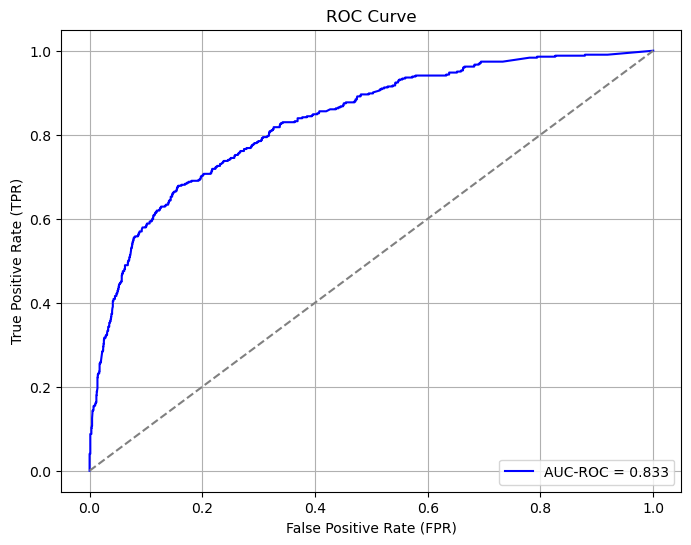

AUC-ROC Score: 0.833
F1 Score: 0.5968


In [54]:
# Create a model using the provided depth, number of estimators, and the same random_state
RF_model = RandomForestClassifier(max_depth=14, random_state=12345, n_estimators=20)

# Train the model using the training dataset
RF_model.fit(features_upsampled, target_upsampled)

# Make predictions on the test set
test_predictions = RF_model.predict(features_test)

# Calculate the F1 score
f1 = f1_score(target_test, test_predictions)

# Calculate probabilities for the test set
probabilities_test = RF_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

# Calculate the AUC-ROC score
auc_roc = roc_auc_score(target_test, probabilities_one_test)

# Calculate the FPR, TPR, and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {round(auc_roc, 4)}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Reference line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Results
print(f'AUC-ROC Score: {round(auc_roc, 4)}')
print(f'F1 Score: {round(f1, 4)}')

**The model meets Beta Bank's expected goals, with an F1 score exceeding 0.5 and an AUC-ROC of 0.833, indicating good model performance.**

In [55]:
# Initialize total variable
total = 0

# Create a loop to check each prediction in the test predictions
for prediction in test_predictions:
    if prediction == 1:
        total += 1

# Print the total number of predicted customers who will leave the bank
print('Predicted total number of customers who will leave the bank:', total)

Predicted total number of customers who will leave the bank: 455


### 4.4.1 Recommendations 

Approximately **22.75%** of the **2,000** customers in the test set, equivalent to **455 customers**, are predicted to leave the bank. This is a significant number, and **Beta Bank** should consider implementing targeted actions to retain these customers, such as personalized offers or closer follow-up to improve customer satisfaction.

### 5. Conclusions

The analysis conducted throughout the project for Beta Bank focused on predicting customer churn using different modeling techniques and adjustments to handle class imbalance in the dataset. 

**Data Description**: A **Churn dataframe** containing customer information and behavior was used. This dataset was crucial for training and evaluating the prediction models.

**Data Preprocessing**: Transformations such as **One-Hot Encoding** for categorical features and data standardization were applied to ensure all features had equal importance in the models.

**Class Imbalance**: The class distribution was highly imbalanced, with the negative class representing about 80% and the positive class only 20%. This imbalance affected the models' ability to adequately predict minority classes.

**Modeling**:
   - **Logistic Regression**: This model was evaluated without adjustments and with **Upsampling** and **Downsampling** techniques to address the class imbalance. Despite these adjustments, it did not achieve the desired performance in terms of **F1 score**.
   - **Decision Tree**: Models were trained using **class_weight='balanced'**, as well as **Upsampling** and **Downsampling** techniques. While improvements were observed with **Upsampling**, the model did not outperform others.
   - **Random Forest**: The **Random Forest** model with **Upsampling** demonstrated the best performance. Using a **maximum depth of 14** and **20 estimators**, it achieved an **F1 score of 0.5931**, meeting Beta Bank's minimum threshold for an acceptable model.

**Best Model**: The **Random Forest with Upsampling** was the best-performing model in terms of **F1 score** and **AUC-ROC**, making it the most suitable option for predicting customer churn for Beta Bank.

**Results Summary**:  
The **RandomForestClassifier** model with a **maximum depth of 14** and **20 estimators** delivered the best overall performance, achieving an **F1 score of 0.613** and an **AUC-ROC score of 0.84274**, standing out as the most balanced model for handling class imbalance.  

- The **DecisionTreeClassifier** showed acceptable performance with different depths but did not surpass Random Forest in terms of **F1 score** and **AUC-ROC**.  
- Class balancing strategies, such as simple balancing, upsampling, and downsampling, improved Logistic Regression results but remained inferior to tree-based methods.  
- This suggests that ensemble methods like Random Forest better capture complex relationships in imbalanced data and offer superior generalization. Hyperparameter tuning (depth and number of estimators) proved critical for maximizing performance.  

While the **AUC-ROC score** was consistently high across models, indicating good ability to distinguish between classes, the **F1 score** provided a more realistic measure of the models' capability to handle the imbalance.  

In conclusion, the **Random Forest model** trained with **Upsampling** is the best choice for Beta Bank, meeting the **F1 score** requirements and demonstrating robust overall performance in churn classification.